In [1]:
import numpy as np
from matplotlib.lines import Line2D
from expm_mul import expm_multiply
from scipy.sparse.linalg import eigs,norm
from scipy.special import factorial
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat
import scipy as sci
from qutip import qload
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_s(A,b,tol):
    s=1
    if A.dtype==np.complex256:
        s=np.ceil(_exact_1_norm(A))
    else:
        while(1):
            norm_A = _exact_inf_norm(A)/s
            max_term_notation=np.floor(norm_A)
            max_term=1
            for i in range(1,np.int(max_term_notation)):
                max_term=max_term*norm_A/i
                if max_term >= 10**16:
                    break
            if 10**-16 * max_term <= tol:
                break
            s=s+1
    return s
def _exact_1_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=0).flat)
    else:
        return np.linalg.norm(A, 1)
def _expm_multiply_simple_core_global(A, B, tol=None):
    """
    A helper function.
    """
    if tol is None:
        tol =1e-16
    s=get_s(A,B,tol)
    F = B

    c1 = _exact_1_norm(B)
    j=0
    while(1):
        coeff = s*(j+1)
        B =  A.dot(B)/coeff
        c2 = _exact_1_norm(B)
        F = F + B
        total_norm=norm_state(F)
        if (c1+c2)<tol:
            m=j+1
            break
        c1 = c2
        j=j+1
    F =  F
    B = F
    for i in range(1,int(s)):
        c1=c2
        for j in range(m):
            coeff = s*(j+1)
            B =  A.dot(B)/coeff
            F = F + B
        F =  F
        B = F
    return F, m*s
def overnorm(A):
    if A.dtype==np.complex256:
        return _exact_inf_norm(A)
    else:
        return norm_two(A)
def _exact_inf_norm(A):
    # A compatibility function which should eventually disappear.
    if sci.sparse.isspmatrix(A):
        return max(abs(A).sum(axis=1).flat)
    else:
        return np.linalg.norm(A, np.inf)
def norm_two(A):
    if sci.sparse.isspmatrix(A):
        A=csr_matrix(A).conjugate().transpose()
        return np.sqrt(abs(eigs(A=A.dot(A),k=1,which='LM',return_eigenvectors=False)[0]))
    else:
        return np.linalg.norm(A)
def norm_state(A):
    return np.linalg.norm(A)
def block_fre(A,E):
    if isspmatrix(A) is False:
        A = np.block([[A, E], [np.zeros_like(A), A]])
    else:
        A = bmat([[A, E], [None, A]]).tocsc()
    return A
def difference(A,B):
    return overnorm(A-B)/overnorm(A)
def get_H(dim,tp):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(HILBERT_SIZE*Q_dim)
    return H,vec
def get_auxiliary(dim,tp,t):
    HILBERT_SIZE=dim
    Q_dim=6
    g=0.1*2*np.pi
    anharmonicity =-0.225
    a_dag = get_creation_operator(HILBERT_SIZE,tp)
    a = get_annihilation_operator(HILBERT_SIZE,tp)
    b_dag=get_creation_operator(Q_dim,tp)
    b=get_annihilation_operator(Q_dim,tp)
    A=np.kron(a,np.identity(Q_dim))
    A_dag=np.kron(a_dag,np.identity(Q_dim))
    B=np.kron(np.identity(HILBERT_SIZE),b)
    B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
    H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
    H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
    H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
    vec=1/np.sqrt(HILBERT_SIZE*Q_dim)*np.ones(2*HILBERT_SIZE*Q_dim)
    vec[0:HILBERT_SIZE*Q_dim]=0
    A=block_fre(t*H,-1j*(B+B_dag))
    return A,vec
def get_norm(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=ts[i]*csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        anorm.append(norm_two(H))
    return anorm
def get_norm_der(ts):
    tp=np.float64()
    anorm=[]
    for i in range(len(ts)):
        HILBERT_SIZE=20
        Q_dim=6
        g=0.1*2*np.pi
        anharmonicity =-0.225
        a_dag = get_creation_operator(HILBERT_SIZE,tp)
        a = get_annihilation_operator(HILBERT_SIZE,tp)
        b_dag=get_creation_operator(Q_dim,tp)
        b=get_annihilation_operator(Q_dim,tp)
        A=np.kron(a,np.identity(Q_dim))
        A_dag=np.kron(a_dag,np.identity(Q_dim))
        B=np.kron(np.identity(HILBERT_SIZE),b)
        B_dag=np.kron(np.identity(HILBERT_SIZE),b_dag)
        H_trans = 1 / 2 * anharmonicity * np.dot(np.dot(b_dag, b),np.dot(b_dag,b)-np.identity(Q_dim))
        H0=g*(np.kron(a_dag,b)+np.kron(a,b_dag))+np.kron(np.identity(HILBERT_SIZE),H_trans)
        H=csr_matrix(-1j*(H0+0.5*2*np.pi*(np.dot(B_dag,B)+B+B_dag+1j*(B-B_dag))))
        A=ts[i]*block_fre(H,-1j*(A+A_dag))
        anorm.append(norm_two(A))
    return anorm

In [2]:
reference = qload('refer')[0]
theta_m=np.array([[8.70950435e-01, 2.48853043e+00, 4.02062662e+00, 5.51075280e+00,
        6.97775212e+00, 8.43027209e+00, 9.87290220e+00, 1.13089234e+01,
        1.27393366e+01, 1.41653119e+01, 1.55887688e+01],
       [1.79283319e-01, 1.30547755e+00, 2.68990434e+00, 4.11674468e+00,
        5.55078449e+00, 6.98409736e+00, 8.41474411e+00, 9.84240944e+00,
        1.12672525e+01, 1.26895571e+01, 1.41096178e+01],
       [0.13,1, 2.2, 3.6,
        4.9, 6.3, 7.7, 9.1,
        11, 12, 1.3],
       [5.87845778e-03, 3.11153531e-01, 1.11496247e+00, 2.19235380e+00,
        3.40348589e+00, 4.68492721e+00, 6.00642014e+00, 7.35228229e+00,
        8.71376145e+00, 1.00856663e+01, 1.14647607e+01],
        [0.003307471010225917,0.24259255239783006,0.9560279579613657,1.9645322216064995,3.1267463661459876,4.372820117778894,5.667919829026178,6.993478543263042,8.338922480962493,9.697877908033124,11.066316441049558 ],
       [2.3e-03, 0.14, 0.64, 1.4,
        2.4, 3.5, 4.7, 6,
        7.2, 8.5, 9.9]])
theta_mm=[]
for j,_theta in enumerate(theta_m):
    a={5:0,10:0,15:0,20:0,25:0,30:0,35:0,40:0,45:0,50:0,55:0}
    for i, theta in enumerate(_theta):
        a[5*(i+1)] = theta
    theta_mm.append(a)

Loaded list object.


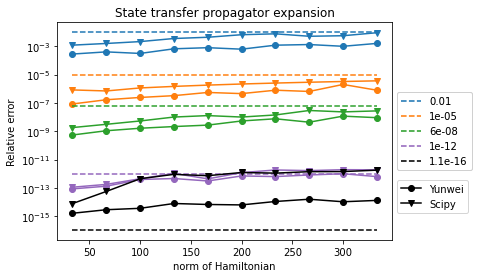

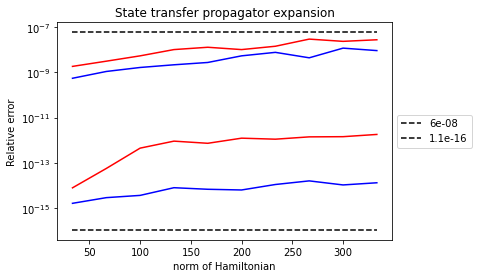

In [4]:
tols=np.array([1e-2,1e-5,2**-24,1e-12,2**-53])
dim=20
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
ref = reference['state_propagator']
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st = (np.array(ref[i],dtype=np.complex256)).reshape(120)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)
        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st=(np.array(ref[i],dtype=np.complex256)).reshape(120)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(t*H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))


norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator expansion')
fig.savefig('State_propagator_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator expansion')
fig.savefig('State_propagator_1.pdf',bbox_inches='tight')

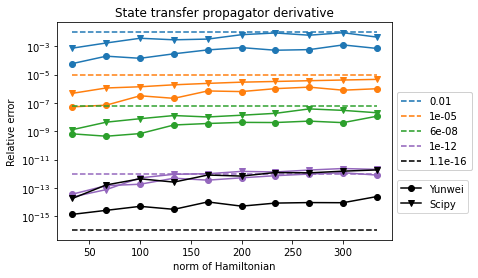

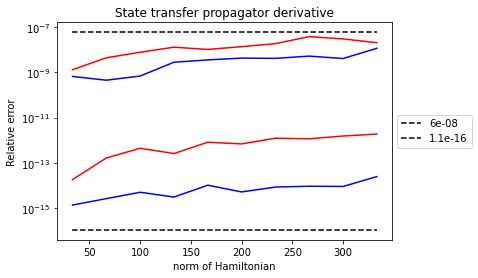

In [6]:
tols=np.array([1e-2,1e-5,2**-24,1e-12,2**-53])
dim=20
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
refer = reference["state_propagator_der"]
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(240)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(240)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator derivative')
fig.savefig('State_propagator_der_0.pdf',bbox_inches='tight')
fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('State transfer propagator derivative')
fig.savefig('State_propagator_der_1.pdf',bbox_inches='tight')

In [60]:
new_error1/new_error

array([[ 12.324016941929575 ,   8.564466144704486 ,  26.00876159552229  ,
          9.735698233197569 ,   5.820951337951608 ,   5.1612402653902665,
         16.563369678686527 ,  10.422680025013594 ,   7.293914783316375 ,
          6.30979509558151  ],
       [  9.052463593834569 ,  16.323659890187336 ,   4.327713055949413 ,
          9.0386824387284   ,   3.426116655833134 ,   4.6270102211834505,
          3.211977566965951 ,   2.8513861097011213,   5.230601877369074 ,
          4.574991168206514 ],
       [  1.9820021607322593,   9.809825354225842 ,  11.264994462362159 ,
          4.635855081552929 ,   2.8969869905746766,   3.669197721118601 ,
          4.466232773900226 ,   7.275515294555044 ,   7.361967967216601 ,
          1.7625532763051572],
       [  0.6279961922417907,   0.5300272099268397,   2.79137603262567  ,
          1.8811981810332674,   2.8321163136844976,   2.8092980301769077,
          1.838565639075191 ,   1.9106426413162205,   1.9702247544318876,
          2.5390489

In [8]:
from qutip import qload
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix,identity
from fractions import Fraction
from scipy.sparse import csr_matrix,isspmatrix,bmat,kron
import scipy as sci
from scipy.sparse import csr_matrix,isspmatrix,bmat
def get_creation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=-1)
def get_annihilation_operator(size,tp):
    return np.diag(np.sqrt(np.arange(1, size),dtype=tp), k=1)
def get_norm(dim):
    tp=np.float64
    anorm=[]
    for i in range(len(dim)):
        N=7
        control=get_control(N,tp)
        control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
        H_control=control_H(control_pra,control)
        H=H_control+get_int(N,tp)
        anorm.append(overnorm(dim[i]*H))
    return anorm
def get_norm_der(dim):
    tp=np.float64
    anorm=[]
    for i in range(len(dim)):
        N=7
        control=get_control(N,tp)
        control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
        H_control=control_H(control_pra,control)
        H=H_control+get_int(N,tp)
        vec=1/np.sqrt(2*2**N)*np.identity(2*2**N)
        A=block_fre(H,-1j*(control[0]))
        anorm.append(overnorm(dim[i]*A))
    return anorm
def get_auxiliary(N,tp,t):
    control=get_control(N,tp)
    H,vec = get_H(N,tp)
    vec=1/np.sqrt(2**N)*np.ones(2*2**N)
    vec[0:2**N]=0
    A=block_fre(t*H,-1j*(control[3]))
    return A,vec
def get_int(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmaz=sigmap.dot(sigmam)
    H0=0
    SIGMAZ=kron(sigmaz,sigmaz)
    H0=H0+kron(SIGMAZ,identity(2**(N-2)))+kron(identity(2**(N-2)),SIGMAZ)
    for i in range(1,N-2):
        H0=H0+kron(kron(identity(2**i),SIGMAZ),identity(2 ** (N - 2 - i)))
    return H0
def get_control(N,tp):
    sigmap=get_creation_operator(2,tp)
    sigmam = get_annihilation_operator(2,tp)
    sigmap=sigmap
    sigmam=sigmam
    sigmax=sigmap+sigmam
    sigmay=-1j*sigmap+1j*sigmam
    control=[]
    if N==1:
        control.append(kron(sigmax, identity(2 ** (N - 1))))
        control.append(kron(sigmay, identity(2 ** (N - 1))))
        return control
    else:
        a=identity(2**(N-1))
        control.append(kron(sigmax,a,format="csc"))
        control.append(kron(sigmay, identity(2 ** (N - 1)),format="csc"))
        for i in range(1,N-1):
            control.append(kron(kron(identity(2**i),sigmax), identity(2 ** (N - 1-i)),format="csc"))
            control.append(kron(kron(identity(2 ** i), sigmay), identity(2 ** (N - 1 - i)),format="csc"))
        control.append(kron(identity(2**(N-1)),sigmax,format="csc"))
        control.append(kron(identity(2**(N-1)),sigmay,format="csc"))
    return control
def control_H(control,H_control):
    H=0
    for i in range(len(control)):
        H=H+control[i]*H_control[i]
    return H
def get_H(N,tp):
    control=get_control(N,tp)
    control_pra=0.5*2*np.pi*np.ones(np.array(control).shape[0])
    H_control=control_H(control_pra,control)
    H=-1j*(H_control+get_int(N,tp)*0.1*2*np.pi)
    vec=1/np.sqrt(2**N)*np.ones(2**N)
    return H,vec


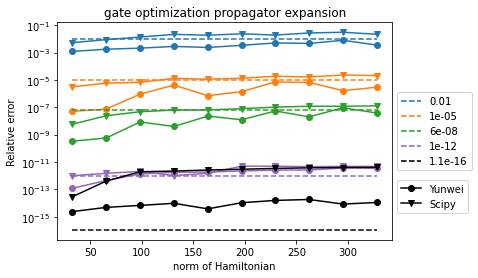

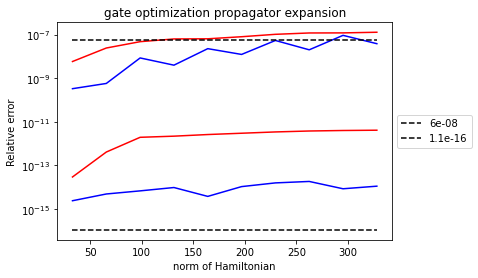

In [11]:
dim=7
tols=np.array([1e-2,1e-5,2**-24,1e-12,2**-53])
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
refer = reference['gate_propagator']
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(128)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(t*H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_H(dim,np.float64)
    H_st,vec=get_H(dim,np.float128)
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(128)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(t*H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))

norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']


legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate optimization propagator expansion')
fig.savefig('gate_propagator_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate optimization propagator expansion')
fig.savefig('gate_propagator_1.pdf',bbox_inches='tight')

In [12]:
yunwei_ms/sci_ms

array([[1.        , 1.03370787, 1.03759398, 1.00546448, 1.05504587,
        1.03564728, 1.05228758, 1.04397163, 1.05076142, 1.05022831],
       [0.91666667, 1.02439024, 1.00983607, 0.95518868, 1.00193424,
        1.00983607, 1.00423729, 0.95744681, 0.99461787, 1.00983284],
       [0.98333333, 0.99578059, 0.96045198, 0.96398305, 0.94594595,
        0.95774648, 0.94437727, 0.94920635, 0.94647887, 0.94594595],
       [1.21126761, 1.16254417, 1.13207547, 1.09450172, 1.08287293,
        1.13500597, 1.12704918, 1.12309075, 1.11376293, 1.10793424],
       [3.84615385, 2.59643917, 2.77196653, 2.74725275, 2.7638191 ,
        2.7486911 , 2.76032316, 2.74941084, 2.74092179, 2.74984287]])

In [13]:
new_error1/new_error

array([[4.37130534e+00, 5.04175420e+00, 6.47523093e+00, 7.59814211e+00,
        7.87954201e+00, 6.95162257e+00, 3.74707837e+00, 5.80949110e+00,
        3.88982692e+00, 6.09174941e+00],
       [6.25932342e+01, 7.83406915e+01, 7.20988094e+00, 3.12296735e+00,
        1.61338153e+01, 9.51359011e+00, 2.60310990e+00, 2.53324817e+00,
        1.40763641e+01, 7.06411545e+00],
       [1.76671031e+01, 4.23549940e+01, 5.58611782e+00, 1.59686590e+01,
        2.83422918e+00, 6.49690680e+00, 1.91766145e+00, 5.92421074e+00,
        1.29654884e+00, 3.35568924e+00],
       [8.32701637e+00, 3.37028876e+00, 1.52429366e+00, 5.82408894e-01,
        8.03468492e-01, 2.23917744e+00, 1.92404383e+00, 1.74946045e+00,
        1.28579323e+00, 1.35448176e+00],
       [1.23149769e+01, 8.42289700e+01, 2.87570441e+02, 2.27702305e+02,
        6.90557561e+02, 2.81667644e+02, 2.18375830e+02, 2.06748555e+02,
        4.72844069e+02, 3.70598242e+02]])

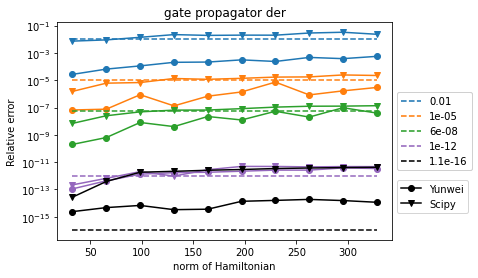

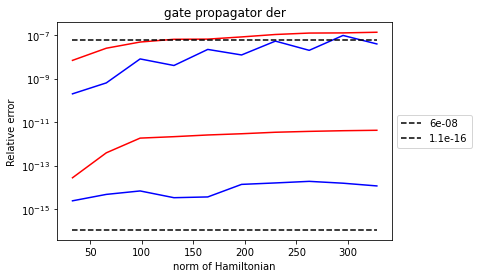

In [15]:
dim=7
ts = np.array([1,2,3,4,5,6,7,8,9,10])
new_error1=np.zeros((len(tols),len(ts)))
new_error=np.zeros((len(tols),len(ts)))
yunwei_ms=np.zeros((len(tols),len(ts)))
sci_ms=np.zeros((len(tols),len(ts)))
refer = reference['gate_propagator_der']
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(256)
    for j, tol in enumerate(tols):
        sas,sci_ms[j][i]=expm_multiply(H, vec, theta_mm[j],tol)

        new_error1[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
for i, t in enumerate(ts):
    H,vec=get_auxiliary(dim,np.float64,t)
    H_st,vec=get_auxiliary(dim,np.float128,t)
    sas_st = (np.array(refer[i],dtype=np.complex256)).reshape(256)
    for j, tol in enumerate(tols):
        sas,yunwei_ms[j][i]=_expm_multiply_simple_core_global(H, vec, tol=tol)
        new_error[j][i]=(norm_two(sas-sas_st)/norm_two(sas_st))
        
norm = get_norm(ts)
tols=np.array([1e-2,1e-5,6.0e-8,1e-12,1.1e-16])
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
color = ['tab:blue','tab:orange','tab:green','tab:purple','k']

legend_elements = [Line2D([0], [0], marker='o', color='k', label='Yunwei',)
                          ,
                  Line2D([0], [0], marker='v', color='k', label='Scipy',)
                          , ]
for i in range(len(new_error1)):
    ax.plot(norm,new_error[i],color = color[i],marker='o')
    ax.plot(norm,new_error1[i],color = color[i],marker='v')
    ax.plot(norm,tols[i]*np.ones(len(new_error1[i])),'--',color=color[i], label= str(tols[i]))
ax.set_yscale('log')
legend2=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend1=ax.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate propagator der')
fig.savefig('gate_propagator_der_0.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
color = ['r','b']
i=2
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[0])),'--',color='k', label= str(tols[2]))
i=4
ax.plot(norm,new_error[i],color = 'b')
ax.plot(norm,new_error1[i],color = 'r')
ax.plot(norm,tols[i]*np.ones(len(new_error1[1])),'--',color='k', label= str(tols[4]))

ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('norm of Hamiltonian')
ax.set_ylabel('Relative error')
ax.set_title('gate propagator der')
fig.savefig('gate_propagator_der_1.pdf',bbox_inches='tight')

In [16]:
yunwei_ms/sci_ms

array([[1.        , 1.07865169, 1.06766917, 1.02459016, 1.0733945 ,
        1.0707457 , 1.07189542, 1.05957447, 1.06598985, 1.0673516 ],
       [1.01851852, 1.02439024, 1.00983607, 0.99056604, 1.00193424,
        1.00983607, 0.98068966, 0.9751773 , 0.99461787, 1.00983284],
       [1.        , 0.99578059, 0.96045198, 0.97881356, 0.94594595,
        0.95774648, 0.94437727, 0.94920635, 0.94647887, 0.94594595],
       [1.02325581, 1.10402685, 1.13207547, 1.09450172, 1.10734463,
        1.13500597, 1.12704918, 1.12309075, 1.11376293, 1.10793424],
       [3.84615385, 2.67062315, 2.77196653, 2.78649922, 2.7638191 ,
        2.77486911, 2.76032316, 2.74941084, 2.75837989, 2.74984287]])

In [17]:
new_error1/new_error

array([[2.71553179e+02, 1.37445528e+02, 1.23738774e+02, 1.06862511e+02,
        8.94804037e+01, 6.46387283e+01, 8.40031768e+01, 6.11629221e+01,
        8.56652271e+01, 4.12937465e+01],
       [2.30534702e+01, 7.98910952e+01, 7.78939972e+00, 1.00891956e+02,
        1.72235726e+01, 9.94430092e+00, 2.33268971e+00, 2.07443555e+01,
        1.46083645e+01, 7.52419144e+00],
       [3.45777270e+01, 3.93226381e+01, 5.97848540e+00, 1.60471908e+01,
        2.97786954e+00, 6.75227982e+00, 2.01493246e+00, 6.22349211e+00,
        1.30794545e+00, 3.45691247e+00],
       [1.96409783e+00, 1.51859006e+00, 1.52839938e+00, 5.65147880e-01,
        1.53427054e+00, 2.24490280e+00, 1.85451320e+00, 1.72022275e+00,
        1.24939964e+00, 1.37195826e+00],
       [1.14751909e+01, 8.17673070e+01, 2.69187950e+02, 6.40922560e+02,
        7.07475957e+02, 2.13222536e+02, 2.14435508e+02, 1.99023190e+02,
        2.59711026e+02, 3.62670962e+02]])